In [1]:
import os
import shutil
import re
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix



In [2]:
raw_data = "C:\\Users\\Shureem Shokri\\Documents\\DEGREE\\YEAR 3\\SEM 2\\FYP\\code\\flower_dataset_extracted\\flowers"

new_dataset_path = "C:\\Users\\Shureem Shokri\\Documents\\DEGREE\\YEAR 3\\SEM 2\\FYP\\code\\flower_dataset_extracted"

In [ ]:
flowers = ['tulip', 'orchids', 'peonies', 'hydrangeas', 'lilies', 'gardenias', 'garden_roses', 'daisies', 'hibiscus', 'bougainvillea', 'sunflower', 'marigold', 'lavender']

for flower in flowers:
    flower_path = os.path.join(new_dataset_path, flower)

    # Check if the directory already exists
    if not os.path.exists(flower_path):
        os.mkdir(flower_path)
        print(f"Directory created for {flower}")
    else:
        print(f"Directory for {flower} already exists")


Directory for tulip already exists
Directory for orchids already exists
Directory for peonies already exists
Directory for hydrangeas already exists
Directory for lilies already exists
Directory for gardenias already exists
Directory for garden_roses already exists
Directory for daisies already exists
Directory for hibiscus already exists
Directory for bougainvillea already exists
Directory created for sunflower
Directory created for marigold
Directory created for lavander


In [8]:
# Move the images to their respective folders and create a dataframe with labels
image_paths = []
labels = []

for image_file in os.listdir(raw_data):
    name_img = re.findall("^[a-z]*_[a-z]*", image_file)[0]

    if name_img[-1] == "_":
        name_img = name_img[:-1]

    source_path = os.path.join(raw_data, image_file)
    destination_path = os.path.join(new_dataset_path, name_img, image_file).replace("\\", "\\\\")
    
    
     # Attempt to load the image
    try:
        image = cv2.imread(source_path)
        if image is None:
            print("Failed to load image:", source_path)
            continue
    except Exception as e:
        print("Error loading image:", source_path)
        print("Error message:", str(e))
        continue  
    
    # Ensure that the destination directory exists before copying
    os.makedirs(os.path.dirname(destination_path), exist_ok=True)
    
    shutil.copyfile(source_path, destination_path)

    image_paths.append(destination_path)
    labels.append(name_img)

data = pd.DataFrame({"image_path": image_paths, "label": labels})


data

# value = data.loc[0,"image_path"]

# value_type = type(value)
# print(value_type)

,image_path,label
0,C:\\Users\\Shureem Shokri\\Documents\\DEGREE\\...,bougainvillea
1,C:\\Users\\Shureem Shokri\\Documents\\DEGREE\\...,bougainvillea
2,C:\\Users\\Shureem Shokri\\Documents\\DEGREE\\...,bougainvillea
3,C:\\Users\\Shureem Shokri\\Documents\\DEGREE\\...,bougainvillea
4,C:\\Users\\Shureem Shokri\\Documents\\DEGREE\\...,bougainvillea
...,...,...
791,C:\\Users\\Shureem Shokri\\Documents\\DEGREE\\...,tulip
792,C:\\Users\\Shureem Shokri\\Documents\\DEGREE\\...,tulip
793,C:\\Users\\Shureem Shokri\\Documents\\DEGREE\\...,tulip
794,C:\\Users\\Shureem Shokri\\Documents\\DEGREE\\...,tulip


In [9]:
#split the dataset into training and testing 

train_data , test_data =train_test_split(data, test_size= 0.2, random_state= 42 )

# train_data['image_path'] = train_data['image_path'].astype(str)
# test_data['image_path'] = test_data['image_path'].astype(str)


test_data

,image_path,label
692,C:\\Users\\Shureem Shokri\\Documents\\DEGREE\\...,peonies
779,C:\\Users\\Shureem Shokri\\Documents\\DEGREE\\...,tulip
63,C:\\Users\\Shureem Shokri\\Documents\\DEGREE\\...,bougainvillea
532,C:\\Users\\Shureem Shokri\\Documents\\DEGREE\\...,lilies
66,C:\\Users\\Shureem Shokri\\Documents\\DEGREE\\...,bougainvillea
...,...,...
588,C:\\Users\\Shureem Shokri\\Documents\\DEGREE\\...,orchids
434,C:\\Users\\Shureem Shokri\\Documents\\DEGREE\\...,hydrangeas
740,C:\\Users\\Shureem Shokri\\Documents\\DEGREE\\...,tulip
512,C:\\Users\\Shureem Shokri\\Documents\\DEGREE\\...,lilies


In [6]:
def preprocess_image(image_path,rotate =False, sharpen = True):
    
    image_path = str(image_path)
    image = cv2.imread(image_path)
    

 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image = cv2.resize(image, (256, 256))  # Resize the image to desired dimensions
    image = image / 255.0  # Normalize the image
    
    if sharpen:
        kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])  # Sharpening kernel
        image = cv2.filter2D(image, -1, kernel)
        
    # plt.imshow(image)
    # plt.show()
    
    # if rotate:
    #     # Apply rotation augmentation (e.g., rotate by 20 degrees)
    #     rotation_angle = 20
    #     rows, cols, _ = image.shape
    #     M = cv2.getRotationMatrix2D((cols / 2, rows / 2), rotation_angle, 1)
    #     image = cv2.warpAffine(image, M, (cols, rows))
    
    return image

In [7]:
# Create an instance of ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,  # Random rotation between -20 and +20 degrees
    width_shift_range=0.2,  # Random horizontal shift
    height_shift_range=0.2,  # Random vertical shift
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True  # Random horizontal flip
)


In [8]:
# Preprocess the training data
train_images = []
train_labels = []

class_to_index = {flower: index for index, flower in enumerate(flowers)}

for _, row in train_data.iterrows():
    image_path = row["image_path"]
    label = row["label"]
    image = preprocess_image(image_path, rotate= True)
    train_images.append(image)
    train_labels.append(class_to_index[label])

train_images = np.array(train_images)
train_labels = to_categorical(train_labels, num_classes=len(flowers))  # Convert labels to one-hot encoded vectors

# Fit the ImageDataGenerator on the training data
datagen.fit(train_images)

In [9]:
# Preprocess the testing data
test_images = []
test_labels = []

for _, row in test_data.iterrows():
    image_path = row["image_path"]
    label = row["label"]
    image = preprocess_image(image_path, rotate = False)
    test_images.append(image)
    test_labels.append(class_to_index[label])

test_images = np.array(test_images)
test_labels = to_categorical(test_labels, num_classes=len(flowers))  # Convert labels to one-hot encoded vectors

test_images

array([[[[ 0.2627451 ,  0.39607843,  0.25098039],
         [ 0.21176471,  0.24705882,  0.36862745],
         [ 0.18039216,  0.24313725,  0.16862745],
         ...,
         [ 0.07843137,  0.11372549,  0.07058824],
         [ 0.1254902 ,  0.19607843,  0.14509804],
         [ 0.03529412,  0.23529412,  0.18823529]],

        [[ 0.21176471,  0.41960784,  0.15686275],
         [ 0.12156863,  0.3254902 ,  0.16078431],
         [ 0.21960784,  0.4627451 ,  0.20392157],
         ...,
         [ 0.22352941,  0.05098039,  0.10196078],
         [ 0.23921569,  0.17647059,  0.0745098 ],
         [ 0.07843137,  0.0627451 ,  0.10980392]],

        [[ 0.18039216,  0.34117647,  0.28235294],
         [ 0.21176471,  0.36078431,  0.21568627],
         [ 0.30196078,  0.30588235,  0.22352941],
         ...,
         [ 0.13333333,  0.16470588,  0.14509804],
         [ 0.07843137,  0.26666667,  0.16470588],
         [ 0.23137255,  0.36078431,  0.25098039]],

        ...,

        [[ 0.19215686,  0.12156863,  0

In [25]:
# Build the classification model for vgg16
vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=(256, 256, 3))
vgg16.feature_extractor = Sequential(vgg16.layers[:-1])
vgg16.feature_extractor.trainable = False

model = Sequential()
model.add(vgg16.feature_extractor)
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(len(flowers), activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.0001), metrics=["accuracy"])


#try to use resnet50 
#momentum - hyperparameter tuning for transfer learning ,diff types of optimizers




In [46]:
# Build the ResNet50 classification model
resnet50 = ResNet50(weights="imagenet", include_top=False, input_shape=(256, 256, 3))
resnet50.trainable = True

fine_tune_at = 100
for layer in resnet50.layers[:fine_tune_at]:
    layer.trainable = False
    
resnet_model = Sequential()
resnet_model.add(resnet50)
resnet_model.add(Flatten())
resnet_model.add(BatchNormalization())
resnet_model.add(Dense(64, activation="relu"))
resnet_model.add(Dense(len(flowers), activation="softmax"))
resnet_model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.0001), metrics=["accuracy"])

In [47]:
# Train the model for vgg16
model.fit(datagen.flow(train_images, train_labels, batch_size=32),
          steps_per_epoch=len(train_images) // 32,epochs=10, validation_data=(test_images,test_labels))

Epoch 1/10
18/18 [==============================] - 95s 5s/step - loss: 0.3960 - accuracy: 0.8827 - val_loss: 0.6107 - val_accuracy: 0.8367
Epoch 2/10
18/18 [==============================] - 103s 6s/step - loss: 0.3734 - accuracy: 0.8953 - val_loss: 0.5798 - val_accuracy: 0.8299
Epoch 3/10
18/18 [==============================] - 97s 5s/step - loss: 0.3036 - accuracy: 0.9167 - val_loss: 0.5329 - val_accuracy: 0.8299
Epoch 4/10
18/18 [==============================] - 94s 5s/step - loss: 0.3213 - accuracy: 0.9188 - val_loss: 0.6048 - val_accuracy: 0.8027
Epoch 5/10
18/18 [==============================] - 94s 5s/step - loss: 0.2706 - accuracy: 0.9332 - val_loss: 0.5305 - val_accuracy: 0.8435
Epoch 6/10
18/18 [==============================] - 94s 5s/step - loss: 0.2459 - accuracy: 0.9440 - val_loss: 0.5257 - val_accuracy: 0.8503
Epoch 7/10
18/18 [==============================] - 95s 5s/step - loss: 0.2530 - accuracy: 0.9332 - val_loss: 0.6249 - val_accuracy: 0.8163
Epoch 8/10
18/18 [=

In [48]:
# Train the model for resnet50
resnet_model.fit(datagen.flow(train_images, train_labels, batch_size=32),
          steps_per_epoch=len(train_images) // 32,epochs=10, validation_data=(test_images,test_labels))



Epoch 1/10
18/18 [==============================] - 115s 6s/step - loss: 2.5086 - accuracy: 0.2527 - val_loss: 5.0826 - val_accuracy: 0.0952
Epoch 2/10
18/18 [==============================] - 100s 6s/step - loss: 1.9064 - accuracy: 0.4711 - val_loss: 3.8450 - val_accuracy: 0.1565
Epoch 3/10
18/18 [==============================] - 101s 6s/step - loss: 1.6417 - accuracy: 0.4910 - val_loss: 3.9035 - val_accuracy: 0.1701
Epoch 4/10
18/18 [==============================] - 100s 6s/step - loss: 1.5558 - accuracy: 0.5560 - val_loss: 3.2188 - val_accuracy: 0.3197
Epoch 5/10
18/18 [==============================] - 100s 6s/step - loss: 1.3598 - accuracy: 0.5993 - val_loss: 2.8693 - val_accuracy: 0.3878
Epoch 6/10
18/18 [==============================] - 100s 6s/step - loss: 1.2792 - accuracy: 0.6065 - val_loss: 3.5115 - val_accuracy: 0.3741
Epoch 7/10
18/18 [==============================] - 100s 6s/step - loss: 1.1975 - accuracy: 0.6119 - val_loss: 4.5453 - val_accuracy: 0.3537
Epoch 8/10
18

5/5 [==============================] - 21s 4s/step
Accuracy: 0.8503401360544217
Precision: 0.8598510522221311
Recall: 0.8503401360544217
F1 Score: 0.8512011629940784
Confusion Matrix:
 [[16  0  0  0  0  0  0  0  0  0]
 [ 0  9  0  1  0  1  0  0  1  0]
 [ 0  0  9  0  0  2  0  0  0  0]
 [ 0  0  2  7  0  0  0  0  0  0]
 [ 0  1  0  0 14  0  1  0  0  0]
 [ 0  0  0  0  0 13  2  0  0  0]
 [ 0  0  0  0  0  0 16  0  0  2]
 [ 0  0  0  0  2  0  0 15  0  0]
 [ 0  0  0  0  1  0  1  0 13  0]
 [ 1  0  1  0  0  0  3  0  0 13]]


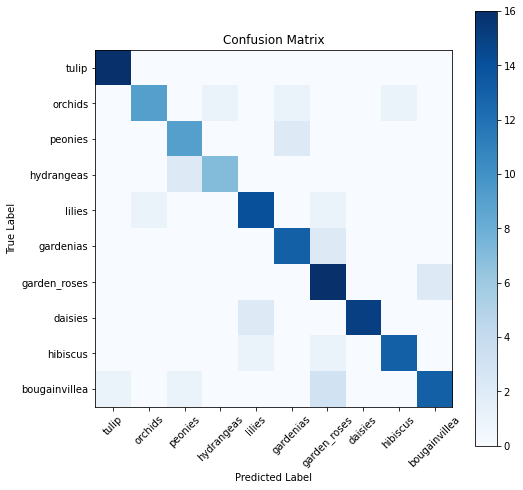

5/5 [==============================] - 10s 2s/step
Accuracy: 0.3673469387755102
Precision: 0.5648793678962268
Recall: 0.3673469387755102
F1 Score: 0.3488612022839578
Confusion Matrix:
 [[ 5  5  0  0  0  4  0  0  0  2]
 [ 0  1  1  0  0  8  0  0  2  0]
 [ 0  0  5  4  0  2  0  0  0  0]
 [ 0  0  0  8  0  1  0  0  0  0]
 [ 0  2  0  0  3  8  1  0  2  0]
 [ 0  0  0  1  0 13  1  0  0  0]
 [ 0  0  3  2  0  4  3  0  0  6]
 [ 0  1  0  1  0  8  0  4  0  3]
 [ 0  0  2  0  0 11  0  0  1  1]
 [ 0  0  0  2  0  4  1  0  0 11]]


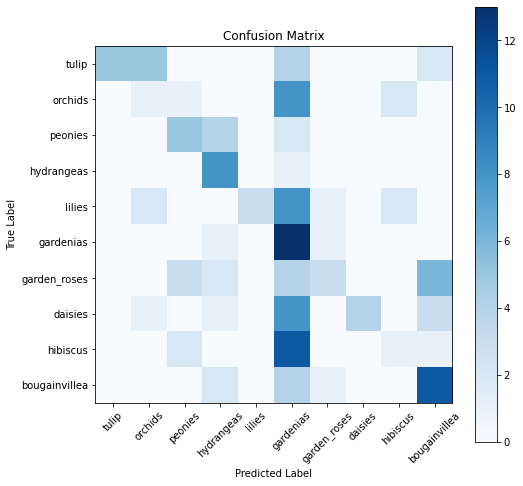

In [51]:
# Function to evaluate the model
def evaluate_model(model, test_images, test_labels, flowers):
    predictions = model.predict(test_images)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(test_labels, axis=1)

    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average="weighted")
    recall = recall_score(true_labels, predicted_labels, average="weighted")
    f1 = f1_score(true_labels, predicted_labels, average="weighted")
    confusion_mat = confusion_matrix(true_labels, predicted_labels)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Confusion Matrix:\n", confusion_mat)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 8))
    plt.imshow(confusion_mat, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(flowers))
    plt.xticks(tick_marks, flowers, rotation=45)
    plt.yticks(tick_marks, flowers)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    
    
conf_matrix =evaluate_model(model, test_images, test_labels, flowers)
conf_matrix =evaluate_model(resnet_model, test_images, test_labels, flowers)

In [64]:
# Save the trained model for vgg16
model.save("flower_classification_model_latest", save_format="tf")



# # Save the trained ResNet50 model
# resnet_model.save("flower_classification_model_resnet50", save_format="tf")


# Load the trained model for vgg16
model = load_model("flower_classification_model_latest")



INFO:tensorflow:Assets written to: flower_classification_model_latest\assets


INFO:tensorflow:Assets written to: flower_classification_model_latest\assets


Try to process a single image from outside of the training and validation set

In [18]:
# Function to preprocess a single image for prediction
def preprocess_single_image(image_path):
    image = preprocess_image(image_path)
    image = np.expand_dims(image, axis=0)
    return image

In [19]:
# Function to predict the class of a single image
# def predict_image_class(image_path):
#     preprocessed_image = preprocess_single_image(image_path)
#     prediction = model.predict(preprocessed_image)
#     predicted_class_index = np.argmax(prediction)
#     predicted_class = flowers[predicted_class_index]
#     return predicted_class

def predict_image_class(model, image_path, flowers):
    preprocessed_image = preprocess_single_image(image_path)
    prediction = model.predict(preprocessed_image)
    predicted_class_index = np.argmax(prediction)
    predicted_class = flowers[predicted_class_index]
    percentage = prediction[0][predicted_class_index] * 100
    return predicted_class, percentage

In [61]:
def predict_top5_classes(model, image_path, flowers):
    preprocessed_image = preprocess_single_image(image_path)
    prediction = model.predict(preprocessed_image)

    # Get indices of top 3 predicted classes
    top5_idx = np.argsort(prediction[0])[::-1][:5]

    # Get the corresponding classes and percentages
    top5_classes = [flowers[i] for i in top5_idx]
    top5_percentages = [prediction[0][i] * 100 for i in top5_idx]

    return top5_classes, top5_percentages



In [53]:
# Example usage: predict the class of a new image
new_image_path = "C:\\Users\\Shureem Shokri\\Documents\\DEGREE\\YEAR 4\\FYP2\\hib.jpg"
predicted_class = predict_image_class(model,new_image_path,flowers)
print("Predicted class:", predicted_class)


1/1 [==============================] - 1s 774ms/step
Predicted class: ('hibiscus', 99.8185932636261)


In [62]:
# To predict top 3 classes of highest percentage
predicted_classes, percentages = predict_top5_classes(model, new_image_path, flowers)
for cls, pct in zip(predicted_classes, percentages):
    print(f"Class: {cls}, Percentage: {pct:.2f}%")

1/1 [==============================] - 0s 228ms/step
Class: hibiscus, Percentage: 99.82%
Class: lilies, Percentage: 0.09%
Class: tulip, Percentage: 0.07%
Class: garden_roses, Percentage: 0.01%
Class: daisies, Percentage: 0.00%


In [ ]:
model.save("flower_classification_model_latest.h5")